# Конкурс для начинающих Data Scientist от ГИС (ГазИнформСервис)
> Команда One Hot Team
## 1. Исходные данные, постановка задачи, методика решения
### 1.1. Формат и типы данных

Нам даны данные с бортовых датчиков в зависимости от временной отметки (timestamp) для транспортных средств за период январь-июнь 2020 года, а именно:

* Показания **альтиметра** и **спидометра** (`vehicleID_speedAndHeight_public.csv`) _в метрах_ и _километрах в час_ соответственно
* Показания **тахометра** (`vehicleID_tachometer_public.csv`) _в оборотах в минуту_
* Показания датчика **замка зажигания** (`vehicleID_ingection_public.csv`) (в формате 0/1, где 0 соответствует выключенному состоянию, а 1 -- включённому)
* Уровень **топлива** (`vehicleID_fuelLevel_public.csv`) в _литрах_

Данные представлены в формате **CSV** (comma-separated-values), а в качестве разделителя используется знак точки с запятой -- `;`.

### 1.2. Понимание предметной области

Компании используют множество транспортных средств для ведения своей деятельности, для лучшего мониторинга технического состояния транспортного средства, специфики его использования, улучшения бизнес-процессов внутри компании на машины часто устанавливают серию датчиков, а затем команда аналитиков пытается выявить какие-то закономерности или аномалии в них.

Одна из частых проблем при эксплуатации автомобиля -- нерациональный расход топлива, который может возникнуть из-за неправильной эксплуатации транспортного средства или из-за прямого вмешательства и механического изменения уровня топлива в нём, что может быть классифицировано как кража.

### 1.3. Формулировка задачи

В ходе анализа данных с бортовых датчиков предлагается решить следующие задачи:
* Выявить заправки топлива
* Выявить сливы (хищения) топлива
* Выявить режим работы техники с наибольшим расходом топлива
* Выявить режимы перевозки грузов
* Определить стиль вождения
* Классифицировать транспортные средства по типам (специальные/грузовые/легковые)

### 1.4. Описание методики решения
1. В задаче **выявления заправок** можно руководствоваться простым эвристическим подходом: если топливо начинает сильно увеличиваться (заметим, что оно может увеличиваться из-за погрешностей и сбоев в работе датчиков топлива, но несильно) за сравнительно небольшой промежуток времени, то это, вероятно, заправка транспортного средства.
2. В задаче **выявления сливов** мы смотрели на несколько характеристик автомобиля: чтобы зажигание было выключено (флаг, отвечающий за зажигание = 0), происходило резкое изменение запаса топлива 

## 2. Препроцессинг данных, выделение признаков

In [1]:
import os
# change working directory to the one with data files
os.chdir('./vehicle_dataset_public/')

In [550]:
# import library for table-view representation and to operate with data more easy
import pandas as pd
import numpy as np
# input files for vehicle: 
# fuelLevel (T), ingection (T), refueling2 (T), speedAndHeight (T), tachometer (T)

In [7]:
# just test open some csv file
df_test = pd.read_csv('./vehicle1_fuelLevel_public.csv', sep=';')
df_test.dtypes

DTIME      object
BEVALUE    object
dtype: object

In [8]:
# take a look at another one
pd.read_csv('./vehicle1_refueling2_public.csv', sep=';')

,TSID,STARTDATE,ENDDATE,STARTLEVEL,ENDLEVEL
0,1,2020-01-16 11:02:40,2020-01-16 13:20:40,"46,7","38,4"
1,1,2020-01-16 13:20:40,2020-01-16 13:25:46,"38,4","56,7"
2,1,2020-01-17 09:05:49,2020-01-17 12:14:10,"56,3",51
3,1,2020-01-17 14:45:48,2020-01-17 16:12:27,51,"43,9"
4,1,2020-01-20 09:44:03,2020-01-20 12:44:07,"43,9","23,5"
...,...,...,...,...,...
98,1,2020-06-26 17:13:03,2020-06-26 18:57:03,"49,3","39,2"
99,1,2020-06-26 18:57:03,2020-06-26 19:04:00,"39,2","59,7"
100,1,2020-06-26 19:04:00,2020-06-26 21:20:41,"59,7","32,2"
101,1,2020-06-26 22:00:39,2020-06-27 00:11:16,"32,2","7,3"


In [11]:
import pandas as pd

In [32]:
# get all files with vehicle word in name
filenames = [filename for filename in os.listdir() if filename.find('vehicle') != -1]

In [33]:
def get_unique_vehicles_sensors(filenames):
    
    """
        function get all filenames in folder with 'csv' files
        and returns the number of unique vehicles and sensors on it
        using filename pattern vehicleID_sensorType_fileType.csv
        where is fileType is public in public data
    """
    
    vehicles, sensors = set(), set()
    for filename in filenames:
        vehicle_name, sensor_type, _ = filename.split('_')
        vehicles.add(vehicle_name)
        sensors.add(sensor_type)
    return list(vehicles), list(sensors)

In [34]:
vehicles, sensors = get_unique_vehicles_sensors(filenames)

In [86]:
# sort vehicle names and sensor types
vehicles.sort()
sensors.sort()

# show it
vehicles, sensors

(['vehicle1', 'vehicle19', 'vehicle28', 'vehicle3', 'vehicle5'],
 ['fuelLevel', 'ingection', 'refueling2', 'speedAndHeight', 'tachometer'])

In [89]:
# let's store all data in pandas Series
# it's useful when you want to get values just saying 
# vehicle_data[vehicle_name].sensorType.sensorValue
# (using dot notation)

vehicles_data = pd.Series()
for vehicle_name in vehicles:
    vehicle = pd.Series()
    for sensor in sensors:
        sensor_df = pd.read_csv('_'.join([vehicle_name, sensor, 'public.csv']), sep=';')
        vehicle[sensor] = sensor_df
    vehicles_data[vehicle_name] = vehicle

In [548]:
# check types of variables in this pandas series
vehicles_data['vehicle1'].fuelLevel.dtypes

# we can see that many of types are just objects
# we really need to convert it to the pandas floats and datetime64's

DTIME      datetime64[ns]
BEVALUE           float64
dtype: object

In [90]:
# let's define some functions to make our preprocessing task easily
# first of all, we can see that in our dataset there is all float numbers
# using comma sign (,) as separator instead of traditional one (.) in pandas
# according to this, we need to replace all commas in floats and convert it to pandas floats
# and with dates we should convert strings to dates using astype function inside our wrapper functions
# such as convert_number for numbers and convert_date for dates

def convert_number(num_as_string):
    """
        function converts numbers from string format N,n (replace all commas with dots) 
        to pandas Series float value format N.n (real number)
    """

    return num_as_string.str.replace(',', '.').astype('float')


def convert_date(date_as_string):
    """
        function converts date from string to datetime64 pandas date format
    """
    
    return date_as_string.astype('datetime64')


# replace commas with dots and change type from object to float64
for vehicle in vehicles:
    # fuelLevel dataset preproccess
    for sensor in sensors:
        sensor_data = vehicles_data[vehicle][sensor]
        values = sensor_data.columns
        for value in values:
            # three types: int | float | date
            # need to become: int->int str->float (if BEVALUE) and not int64 already
            # check correctness using print(vehicle, sensor, sensor_data, value)
            if sensor_data[value].dtype == 'object':
                date_like_columns = ['DTIME', 'STARTDATE', 'ENDDATE']
                if value in date_like_columns:
                    sensor_data[value] = convert_date(sensor_data[value])
                else:
                    sensor_data[value] = convert_number(sensor_data[value])
            # if type is not object do nothing (cause int64 -> (goes to) int64 by default)

In [91]:
# let's take a look at dtypes again
vehicles_data['vehicle1'].fuelLevel.dtypes

DTIME      datetime64[ns]
BEVALUE           float64
dtype: object

In [537]:
# good news, we've got right types in series
# so, generate some new basic features such as 
# max_fuel, avg_speed and so on

for vehicle in vehicles:
    # fuel level features
    current_vehicle = vehicles_data[vehicle]
    df = current_vehicle.fuelLevel
    current_vehicle['max_fuel'] = df.BEVALUE.max()
    
    # height features
    df = current_vehicle.speedAndHeight
    current_vehicle['max_height'] = df.HEIGHT.max()
    current_vehicle['min_height'] = df.HEIGHT.min()
    current_vehicle['avg_height'] = df.HEIGHT.mean()
    current_vehicle['range_height'] = df.HEIGHT.max() - df.HEIGHT.min()
    
    # speed features
    vehicles_data[vehicle]['max_speed'] = df.SPEED.max()
    # vehicles_data[vehicle]['min_speed'] = df.SPEED.min() -- not informative cause min is 0 for all
    vehicles_data[vehicle]['avg_speed'] = df.SPEED.mean()
    # vehicles_data[vehicle]['range_speed'] = df.SPEED.max() - df.SPEED.min() -- not informative cause max_speed
    
    # tachometer features
    df = current_vehicle.tachometer
    current_vehicle['avg_rotations'] = df.BEVALUE.mean()
    current_vehicle['median_rotations'] = df.BEVALUE.median()

## 3. Гипотезы классификации

Базовый визуальный анализ значений максимального уровня топлива в баках за весь предоставленный период времени может свидетельствовать о том, что ``vehicle28`` и ``vehicle1`` с максимальным объемом в 60 литров с большой вероятностью являются **легковыми автомобилями**.

Таким же является `vehicle5` с максимальным объемом в 73.5 литра.

Транспортное средство с идентификатором `vehicle19` относится к типу специальной техники, о чём свидетельствует большая вместимость топливного бака, а также (как мы увидим ниже, рассматриая двумерный разрез в пространстве признаков "скорость - объем бака") расположение кластеров на графике.

``vehicle3`` -- фура с самым большим из представленных баков, предназначена для транспортировки грузов на дальние расстояния, магистральный тягач типа MAN, 279.8 (280) литров.

Разделение (или как ещё говорят при построении деревьев решений -- расщепление) набора данных о транспортных средствах всего лишь по одному этому критерию даёт достаточно большую точность классификации (кластеризации), что очень неплохо, а самое главное -- интуитивно угадываемо и понятно.

Давайте двигатья в решении этой задачи далее!

## 4. Создание датасета для классификации транспортных средств

Поскольку большое число признаков в нашей задаче генерировать особого смысла не имеет (например, потому что существуют такие явные признаки, на основании которых тестовая выборка уже неплохо разделима), то для решения **задачи классификации транспортных средств** мы воспользуемся такими признаками как:
* Медианное и среднее значения оборотов длвигателя за весь период наблюдений
* Размах (разность между максимальным и минимальным значениями) высот
* Максимальная и средняя скорость передвижения транспортного средства
* Максимальные значения уровня топлива (что может быть интерпретировано как вместимость бака)
и некоторые другие

На основании вышеописанных признаков мы составим небольшой датасет, где обучающими примерами выступят представленные транспортные средства (5 штук).

Обратим внимание, что здесь же мы проделали подготовительную работу по выделению временных промежутков слива и заправки топлива (`defuel_periods` и `fuel_periods` соответственно) для каждого транспортного средства, а также предполагаемый суммарный расход топлива за весь период наблюдений и предполагаемое расчётное число "слитых" литров топлива (`sum_fuel` и `sum_defuel`).

In [538]:
# make dataframe with new features
vehicles_df = pd.DataFrame()
for vehicle in vehicles:
    # get only features generated by us
    generated_features = list(set(vehicles_data[vehicle].index) - set(sensors))
    vehicles_df[vehicle] = vehicles_data[vehicle][generated_features]

In [539]:
# let's just watch on this new dataframe 
vehicles_df

,vehicle1,vehicle19,vehicle28,vehicle3,vehicle5
min_height,-1503.6,-46.6,-2561.8,-79.7,-3228.2
avg_speed,52.3975,1.98549,42.1614,29.6963,59.0354
avg_height,37.0444,81.3893,61.5954,56.7928,52.983
range_height,3697,2859.4,2937.1,246.8,6486.9
sum_fuel,12535.7,985.3,20245.3,5141.3,11151.5
defuel_periods,"4288 2020-02-25 09:19:18 Name: DTIME, dtype:...","Series([], Name: DTIME, dtype: datetime64[ns])",232 2020-01-09 16:25:33 993 2020-01-14...,"Series([], Name: DTIME, dtype: datetime64[ns])","Series([], Name: DTIME, dtype: datetime64[ns])"
median_rotations,2400,1190,2272,1186.5,1968
sum_defuel,31.7,0,1869.1,0,0
max_height,2193.4,2812.8,375.3,167.1,3258.7
avg_rotations,2315.6,1166.82,1914.68,1197.5,1889.08


In [540]:
# let's transpose our vehicles dataset to make it fit
# traditional form where rows is objects and columns is features
vdft = vehicles_df.transpose()
vdft

,min_height,avg_speed,avg_height,range_height,sum_fuel,defuel_periods,median_rotations,sum_defuel,max_height,avg_rotations,fuel_periods,max_fuel,max_speed
vehicle1,-1503.6,52.3975,37.0444,3697,12535.7,"4288 2020-02-25 09:19:18 Name: DTIME, dtype:...",2400,31.7,2193.4,2315.6,3 2020-01-09 10:05:26 25 2020-01-14...,60,129
vehicle19,-46.6,1.98549,81.3893,2859.4,985.3,"Series([], Name: DTIME, dtype: datetime64[ns])",1190,0,2812.8,1166.82,464 2020-01-13 07:22:33 2011 2020-03-03 1...,95,57
vehicle28,-2561.8,42.1614,61.5954,2937.1,20245.3,232 2020-01-09 16:25:33 993 2020-01-14...,2272,1869.1,375.3,1914.68,2 2020-01-09 08:19:06 5 2020-01-09...,60,122
vehicle3,-79.7,29.6963,56.7928,246.8,5141.3,"Series([], Name: DTIME, dtype: datetime64[ns])",1186.5,0,167.1,1197.5,1 2020-01-09 08:40:43 273 2020-02-10 0...,279.8,227
vehicle5,-3228.2,59.0354,52.983,6486.9,11151.5,"Series([], Name: DTIME, dtype: datetime64[ns])",1968,0,3258.7,1889.08,19 2020-01-10 09:57:40 62 2020-01-10...,73.5,132


In [108]:
# importing libraries for visualisation (plotting tools)
from matplotlib import pyplot as plt

In [156]:
# let's reduce dimensionality (by taking only two of features) 
# and watch feature space as plane
dp = list(vdft[['max_fuel', 'avg_speed']].values)
dp

[array([60.0, 52.397460664742574], dtype=object),
 array([95.0, 1.985494106980961], dtype=object),
 array([60.0, 42.161399705980195], dtype=object),
 array([279.8, 29.696296296296296], dtype=object),
 array([73.5, 59.03544883970601], dtype=object)]

In [157]:
# let's call first feature X, the second one y
X = [el[0] for el in dp]
y = [el[1] for el in dp]

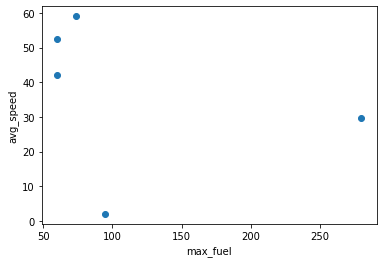

<Figure size 864x864 with 0 Axes>

In [393]:
# and plot it
plt.scatter(X, y)
# set label for first feature
plt.xlabel('max_fuel')
# and also for the second one
plt.ylabel('avg_speed')
plt.figure(figsize=(12,12))
plt.show()
# so we can see some kind of clusters, huh?

In [335]:
for vehicle in vehicles:
    fuel_values = list(vehicles_data[vehicle].fuelLevel.BEVALUE)
    fuel_times = list(vehicles_data[vehicle].fuelLevel.DTIME)
    in_drive_flag = list(vehicles_data[vehicle].ingection.BEVALUE)
    
    defuel_indexes = []
    defuel_amounts = []
    fuel_indexes = []
    fuel_amounts = []
    
    DEFUEL_THRESHOLD = 10 # litres
    FUEL_THRESHOLD = 20 # litres
    
    for i in range(0, len(fuel_values) - 1):
        # defuels
        if (fuel_values[i] - fuel_values[i+1] > DEFUEL_THRESHOLD) and \
            ((fuel_times[i+1] - fuel_times[i]).total_seconds() < 100) and \
            (in_drive_flag[i] == 0):
            defuel_indexes.append(i)
            defuel_amounts.append(fuel_values[i])

        # fuels
        if ((fuel_values[i+1] - fuel_values[i]) > FUEL_THRESHOLD):
            fuel_indexes.append(i+1)
            fuel_amounts.append(fuel_values[i+1])
    
    # add this info to vehicle data
    current_vehicle = vehicles_data[vehicle]
    df = current_vehicle.fuelLevel
    current_vehicle['fuel_periods'] = df.DTIME[fuel_indexes]
    current_vehicle['defuel_periods'] = df.DTIME[defuel_indexes]
    
    # add info about sum of fuels / defuels
    current_vehicle['sum_fuel'] = sum(fuel_amounts)
    current_vehicle['sum_defuel'] = sum(defuel_amounts)

## 5. Решение задачи кластеризации методом К средних (K-means)
Метод К средних при решении задач кластеризации хорош тем, что он явно позволяет задать необходимое число кластеров для решения задачи кластеризации (мы условились считать, что кластеров в нашей задаче 3: грузовые автомобили, легковые и специального назначения.

In [408]:
# import clusterizer from library for classic machine learning algorithms implementations
from sklearn.cluster import KMeans

In [488]:
clusterizer = KMeans(n_clusters = 3)
# clusterize by 3 features: average speed, 
# average height above the sealevel, and maximum fuel level
clusterizer.fit(vdft[['avg_speed', 'avg_height', 'max_fuel']])
X = np.array(vdft.avg_speed)
y = np.array(vdft.max_fuel)

In [490]:
labels = np.array(clusterizer.labels_)

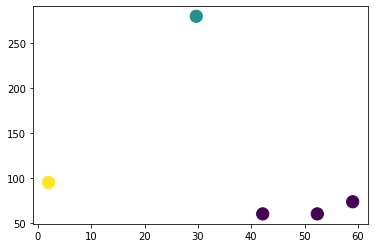

In [491]:
plt.scatter(X, y, c=labels, s=150)

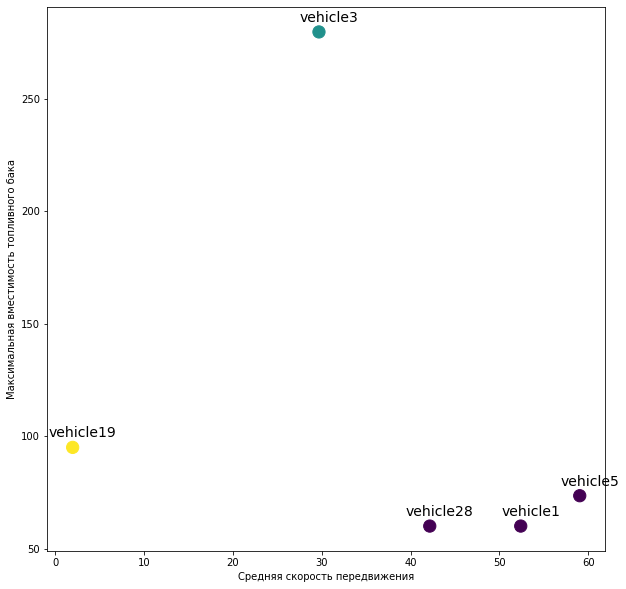

In [531]:
plt.figure(figsize=(10, 10))
plt.scatter(X, y, c=labels, s=150)
plt.xlabel('Средняя скорость передвижения')
plt.ylabel('Максимальная вместимость топливного бака')

# let's annotate all points by vehicle name (vehicleID)
for point in enumerate(zip(X, y)):
    
    label = vdft.index[point[0]]
    x_ = point[1][0]
    y_ = point[1][1]

    plt.annotate(label, # this is the text
    (x_, y_), # this is the point to label
    textcoords="offset points", # how to position the text
    xytext=(10, 10), # distance from text to points (x,y)
    fontsize=14,
    ha='center') # horizontal alignment can be left, right or center
plt.show()

## 6. Решение задачи классификации сливов/заправок методом KNN

KNN -- K Nearest Neighbors, К ближайших соседей. Новый объект относится к тому классу, объекты какого класса преобладают рядом с тем, для которого мы строим предсказание. Имплементация данного метода осуществляется посредством двух файлов, которые лежат в корне репозитория с решением:
* ``get_data.py`` -- получаем данные и признаки из них (обработка осуществляется аналогично тому, как мы делаем в этом файле, см. обход файлов, транспортных средств и датчиков выше в этом ноутбуке)
* ``knn.py`` -- основной файл, решающий задачу классификации всех периодов времени на сливы и заправки (бинарная классификация). Подробную реализацию метода и подходы к решению данной задачи смотрите именно в этом файле, снабжённым достаточным количеством комментариев для понимания происходящего внутри

1 тип классификации выданных данных:

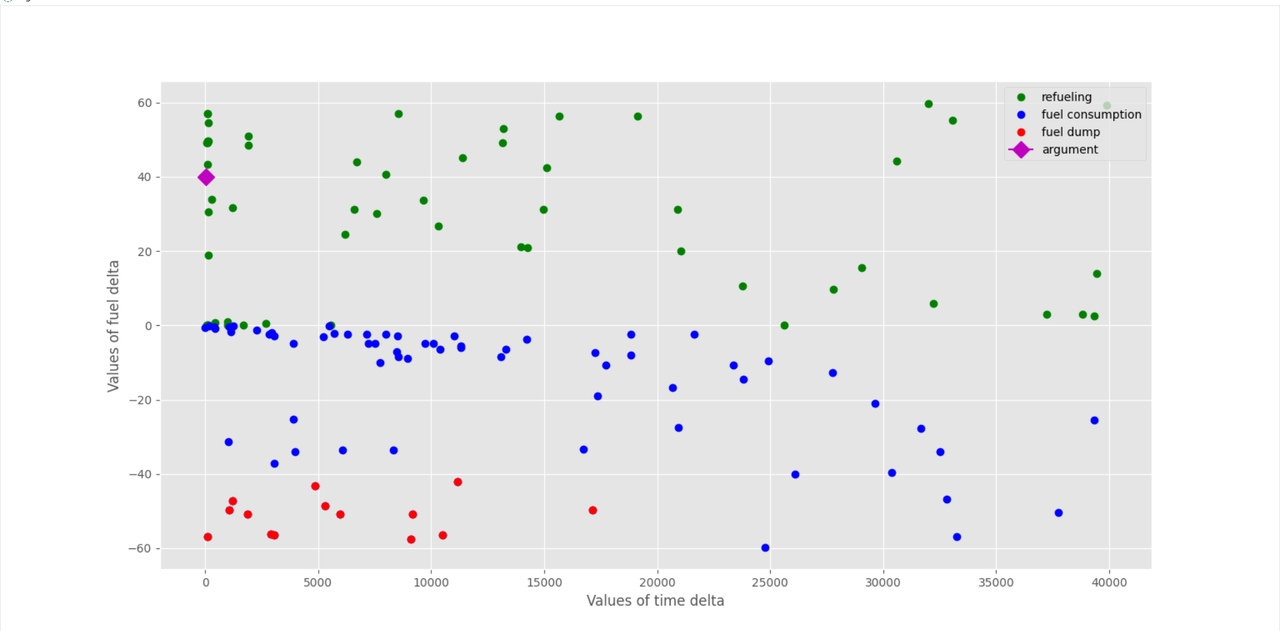

2 тип классификации выданных данных:

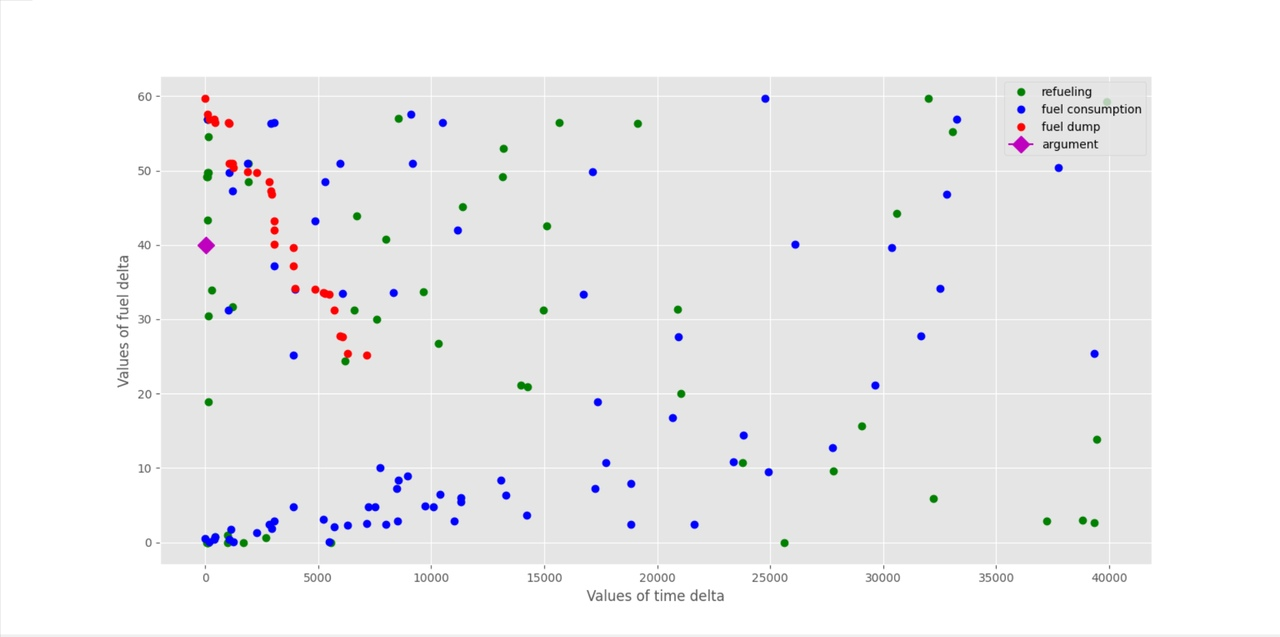

## 7. Остальные задачи

Оставшиеся задачи из перечня для решения мы посчитали логичным выделить в отдельную сущность, отдельный Jupyter-ноутбук, а именно: задача классификации стилей вождения, выявления режимов наибольшего расхода топлива, а также режимов перевозки грузов решены и подробно описаны в файлах `Driving Style Classification.ipynb` и `Anti-Cruising State Search.ipynb`.